### Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error

### Reading data

The dataset contains temperature readings inside and outside of a room. The data is from Jan 2018 to Nov 2018.\
The device which measures the temperature was shut down several times using the entire period 28-07-2018 to 08-12-2018.\
We have 5 columns.
- id (unique ID for readings)
- room_id/id (room in which device was installed)
- noted_date (date and time of the reading)
- temp (temperature reading)
- out/in (reading taken inside or outside)

In [2]:
df=pd.read_csv("/kaggle/input/temperature-readings-iot-devices/IOT-temp.csv",\
               parse_dates=['noted_date'])
df.head()

,id,room_id/id,noted_date,temp,out/in
0,__export__.temp_log_196134_bd201015,Room Admin,2018-08-12 09:30:00,29,In
1,__export__.temp_log_196131_7bca51bc,Room Admin,2018-08-12 09:30:00,29,In
2,__export__.temp_log_196127_522915e3,Room Admin,2018-08-12 09:29:00,41,Out
3,__export__.temp_log_196128_be0919cf,Room Admin,2018-08-12 09:29:00,41,Out
4,__export__.temp_log_196126_d30b72fb,Room Admin,2018-08-12 09:29:00,31,In


### Preprocessing

Converting noted_date to Datetime format

In [3]:
df['Date']=pd.to_datetime(df['noted_date'])

Drop the columns id, room_id and noted_date.\
We require only the Date, temperature and in/out column.

In [4]:
df.drop(['id','room_id/id','noted_date'],axis=1,inplace=True)

In [5]:
df.head()

,temp,out/in,Date
0,29,In,2018-08-12 09:30:00
1,29,In,2018-08-12 09:30:00
2,41,Out,2018-08-12 09:29:00
3,41,Out,2018-08-12 09:29:00
4,31,In,2018-08-12 09:29:00


Extracting Year, Month, Date, Week information

In [6]:
df['Date']=pd.to_datetime(df.Date)
df['Year']=df.Date.dt.year
df['Month']=df.Date.dt.month
df['Day']=df.Date.dt.day
df['Week']=df.Date.dt.weekofyear
df['Hour']=df.Date.dt.hour

In [7]:
df.sort_values('Date',inplace=True)
df.head()

,temp,out/in,Date,Year,Month,Day,Week,Hour
16218,32,In,2018-01-11 00:06:00,2018,1,11,2,0
16217,40,Out,2018-01-11 00:07:00,2018,1,11,2,0
16216,39,Out,2018-01-11 00:09:00,2018,1,11,2,0
16215,40,Out,2018-01-11 00:13:00,2018,1,11,2,0
16214,40,Out,2018-01-11 00:23:00,2018,1,11,2,0


Checking for NULL and DUPLICATES

In [8]:
df.isnull().sum()

temp      0
out/in    0
Date      0
Year      0
Month     0
Day       0
Week      0
Hour      0
dtype: int64

There are no null values

In [9]:
df.duplicated().sum()/df.shape[0]*100

61.81792102944491

We have 61.81% Duplicat values. We will remove all the duplicate values. We keep only the first value.

In [10]:
df.drop_duplicates(subset=['temp','out/in','Date'],keep='first',inplace=True)
df.duplicated().sum()

0

No more duplicate values!

Checking the percentage of the in/out variales.

In [11]:
df['out/in'].value_counts()/df.shape[0]*100

Out    73.322958
In     26.677042
Name: out/in, dtype: float64

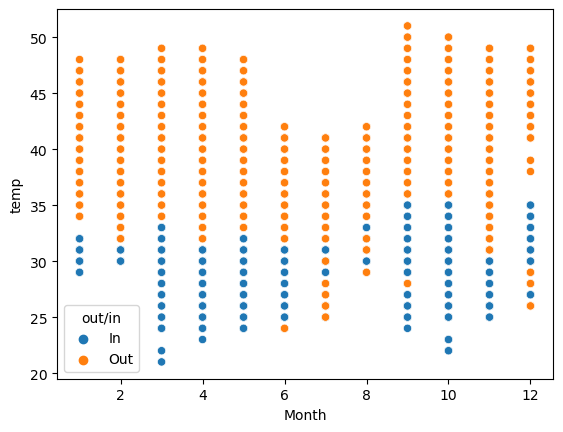

In [12]:
sns.scatterplot(x="Month",y="temp",hue='out/in',data=df)
plt.show()

We have more data for 'Out' (i.e. temperatures are recorded more outside room) 

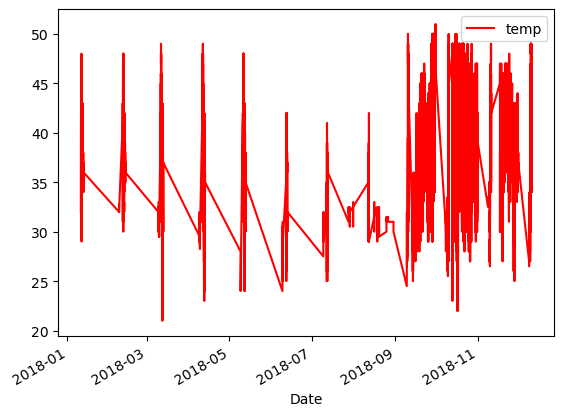

In [13]:
df[['Date','temp','out/in']].groupby(df.Date).mean().plot(c='red')
plt.show()

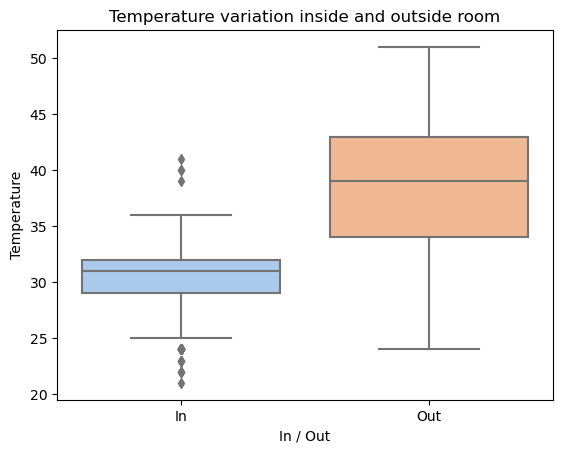

In [15]:
sns.boxplot(data=df,x='out/in',y='temp',palette='pastel')
plt.xlabel("In / Out")
plt.ylabel("Temperature")
plt.title("Temperature variation inside and outside room")
plt.show()

In [16]:
print(f"INSIDE ROOM - \n\
Min Temperature : {df['temp'][df['out/in']=='In'].min()}\n\
Max Temperature : {df['temp'][df['out/in']=='In'].max()}\n\
OUTSIDE ROOM - \n\
Min Temperature : {df['temp'][df['out/in']=='Out'].min()}\n\
Max Temperature : {df['temp'][df['out/in']=='Out'].max()}")

INSIDE ROOM - 
Min Temperature : 21
Max Temperature : 41
OUTSIDE ROOM - 
Min Temperature : 24
Max Temperature : 51


Average temperature recorded inside the room **<** Average temperature recorded outside\
Temperature varies a lot outside of the room

### How do temerature vary across seasons?

In [17]:
def map_to_seasons(month):
    if month in [12,1,2]:
        season='Winter'
    elif month in [3,4,5]:
        season='Summer'
    elif month in [6,7,8,9]:
        season='Monsoon'
    elif month in [10,11]:
        season='Post_Monsoon'
    return season

In [18]:
df['Season']=df['Month'].apply(lambda x: map_to_seasons(x))

In [19]:
df['Season'].value_counts()

Post_Monsoon    19349
Monsoon          9980
Summer           4318
Winter           3621
Name: Season, dtype: int64

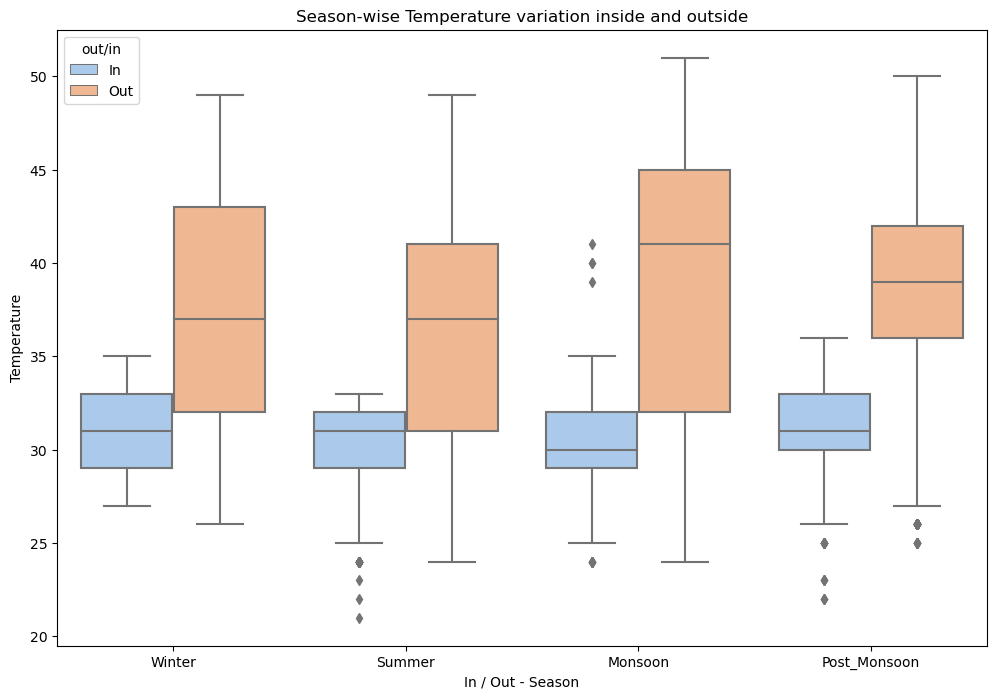

In [20]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df,x='Season',y='temp',hue='out/in',palette='pastel')
plt.xlabel("In / Out - Season")
plt.ylabel("Temperature")
plt.title("Season-wise Temperature variation inside and outside")
plt.show()

### How do temerature vary across Months?

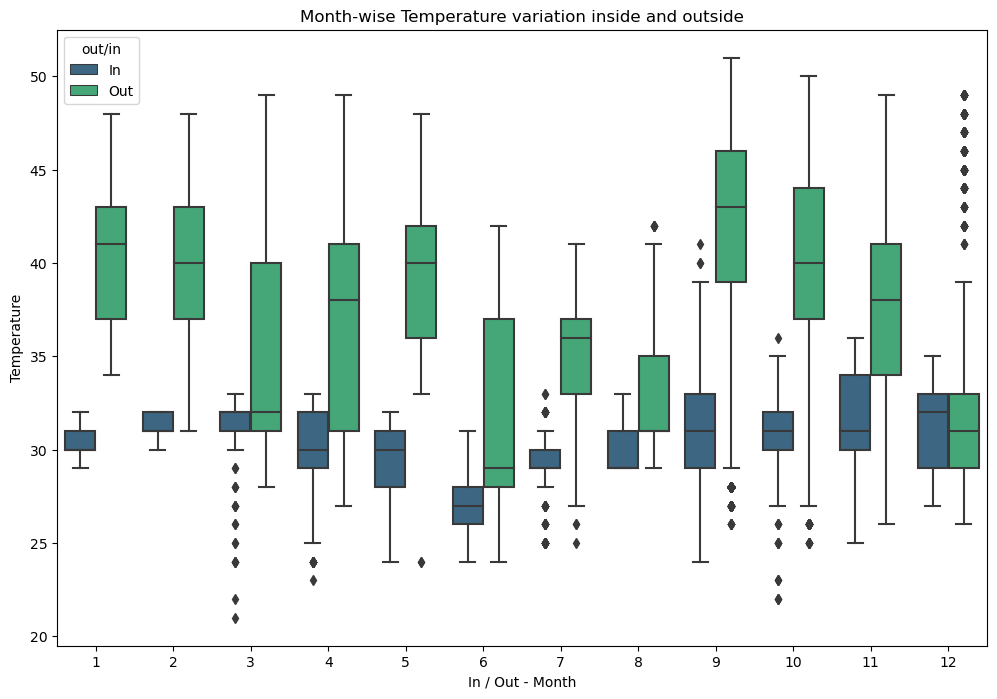

In [21]:
plt.figure(figsize=(12,8))
sns.boxplot(data=df,x='Month',y='temp',hue='out/in',palette='viridis')
plt.xlabel("In / Out - Month")
plt.ylabel("Temperature")
plt.title("Month-wise Temperature variation inside and outside")
plt.show()

The volume of data is very low  in 
- January first half
- February first half
- July
- August
Highest Average temperature is observed in **September**

### How does temperature vary daily across months ?

In [22]:
def hours_into_timing(hour):
    
    if hour in [22,23,0,1,2,3]:
        timing = 'Night'
    elif hour in range(4, 12):
        timing = 'Morning'
    elif hour in range(12, 17):
        timing = 'Afternoon'
    elif hour in range(17, 22):
        timing = 'Evening'
    else:
        timing = 'X'
        
    return timing

In [23]:
df['Timing']=df['Hour'].apply(lambda x: hours_into_timing(x))

In [24]:
df['Timing'].value_counts()

Morning      12682
Night         8550
Afternoon     8349
Evening       7687
Name: Timing, dtype: int64

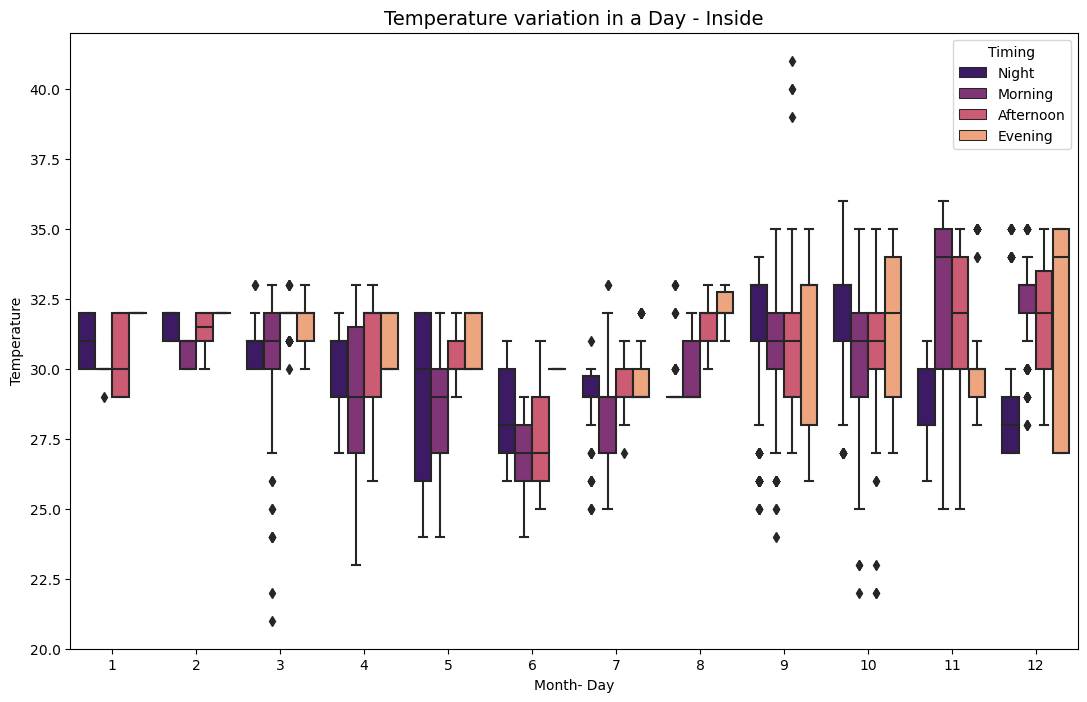

In [25]:
plt.figure(figsize=(13,8))
sns.boxplot(data=df[df['out/in']=='In'],x='Month',y='temp',hue='Timing',palette='magma')
plt.xlabel("Month- Day")
plt.ylabel("Temperature")
plt.title("Temperature variation in a Day - Inside",fontsize=14)
plt.show()

#### Observations - Inside Room
- Very few data available in January, February, July, August to observe
- Lowest temperature observed in **March** Morning.
- Highest temperature observed in **September** Afternoon.
- Over the first 5 months (Jan-May) the highest temperature is almost same, around 32.5

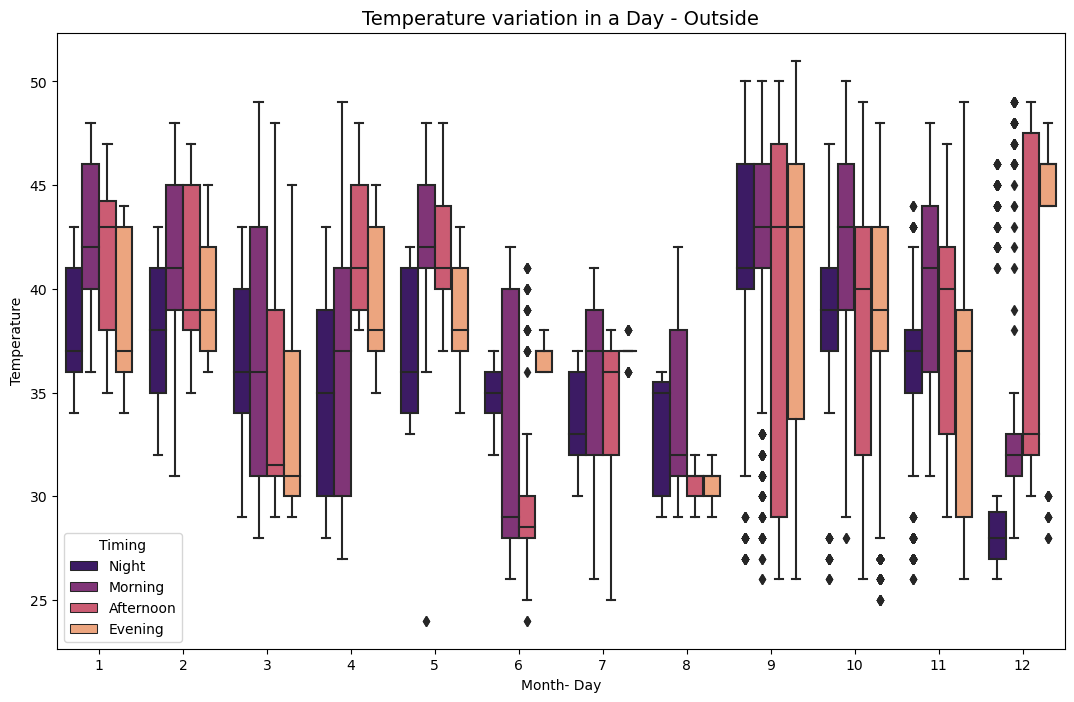

In [26]:
plt.figure(figsize=(13,8))
sns.boxplot(data=df[df['out/in']=='Out'],x='Month',y='temp',hue='Timing',palette='magma')
plt.xlabel("Month- Day")
plt.ylabel("Temperature")
plt.title("Temperature variation in a Day - Outside",fontsize=14)
plt.show()

#### Observations - Outside Room
- Very few data available in June, July, August to observe
- Lowest temperature observed in **May** Morning and **June** Evening.
- Highest temperature variation observed in **September** Afternoon.

Separate Date

In [27]:
df.Date=df.Date.dt.date
df.sort_values('Date',inplace=True)

In [28]:
df.head()

,temp,out/in,Date,Year,Month,Day,Week,Hour,Season,Timing
16218,32,In,2018-01-11,2018,1,11,2,0,Winter,Night
15899,43,Out,2018-01-11,2018,1,11,2,16,Winter,Afternoon
15900,32,In,2018-01-11,2018,1,11,2,15,Winter,Afternoon
15901,31,In,2018-01-11,2018,1,11,2,15,Winter,Afternoon
15902,32,In,2018-01-11,2018,1,11,2,15,Winter,Afternoon


Resample the data according to day. Take daily mean values

In [49]:
ts_temp=df[['temp','Date']]
ts_temp['Date'] = pd.to_datetime(ts_temp['Date'])
ts_temp = ts_temp.set_index('Date')
ts_temp=ts_temp.resample('D').mean()

In [50]:
ts_temp.head()

,temp
Date,
2018-01-11,40.660870
2018-01-12,37.379501
2018-01-13,NaN
2018-01-14,NaN
2018-01-15,NaN


Generate the missing dates and fill in the missing values.\
This is down do that our time series data is continues (having everyday values)

In [77]:
date_range = pd.date_range(start=ts_temp.index.min(), end=ts_temp.index.max(), freq='D')
date_range=pd.DataFrame(date_range)
date_range.columns=['date']

data=pd.merge(ts_temp,date_range,how='right',right_on='date',left_on='Date')

data.set_index(data['date'],inplace=True)
data.fillna(method='bfill',inplace=True)

In [78]:
data.isnull().sum()

temp    0
date    0
dtype: int64

In [79]:
data.drop(['date'],axis=1,inplace=True)

### ADFuller Test - to check for stationarity

In [97]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data[['temp']])
print(f"p-value : {result[1]}\n")

if result[1] > 0.05:
    print("making data staionary")
    data = data.diff().dropna()
else:
    print("stationary")

p-value : 0.04660866440538212

stationary



**p-value < 0.05**\
We reject the null hypothesis and accept alternate hypothesis.\
Therefore, data is **STATIONARY**

d=1 (as we did not do any differencing)

### Trends, Seasonality, Cycles

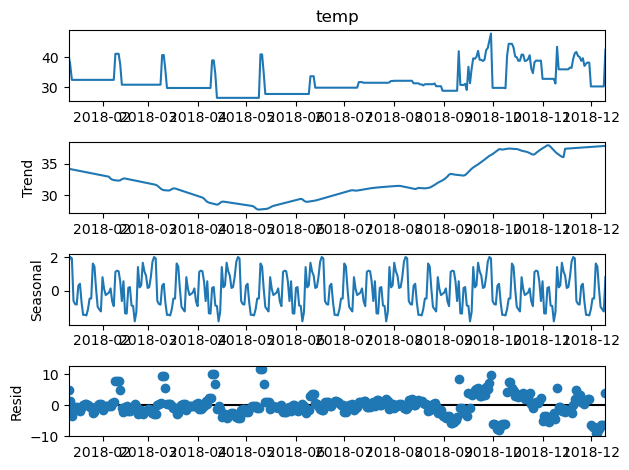

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp=seasonal_decompose(data['temp'],period=52,model='additive',extrapolate_trend='freq')
data['temp_trend']=decomp.trend
data['temp_seasonal']=decomp.seasonal
decomp.plot()
plt.tight_layout()
plt.show()

#### Seasonal Plot of the tempreature

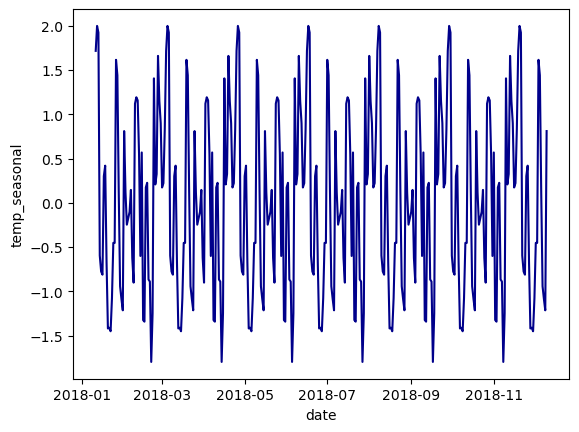

In [99]:
sns.lineplot(x=data.index,y=data['temp_seasonal'],color='darkblue')
plt.show()

### ACF, PACF plots

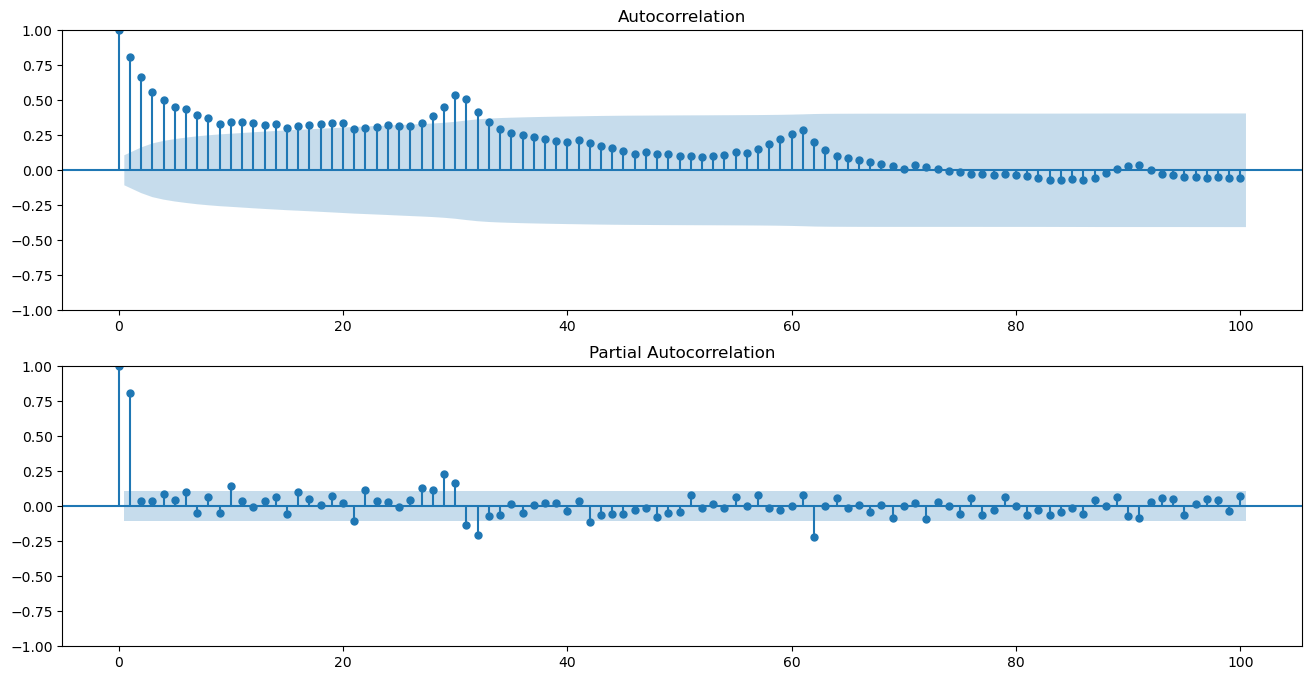

In [100]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data['temp'], lags=100, ax=ax[0])
plot_pacf(data['temp'], lags=100, ax=ax[1])

plt.show()

p=1 and q=1

Dividing the data to train and test data to forecast.

In [101]:
train_size=int(0.85* len(data))
test_size=len(data)-train_size

univariate_df=data.copy()
univariate_df=univariate_df[['temp']]
univariate_df.columns=['y']

train=univariate_df.iloc[:train_size,:]

x_train,y_train=pd.DataFrame(univariate_df.index[:train_size]), pd.DataFrame(univariate_df.iloc[:train_size, 0])
x_valid,y_valid=pd.DataFrame(univariate_df.index[train_size:]), pd.DataFrame(univariate_df.iloc[train_size:, 0])

print(len(train),len(x_valid))

283 51


In [102]:
import statsmodels.api as sm

order = (1, 0, 1) 
model = sm.tsa.arima.ARIMA(train, order=order)
model_fit = model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [103]:
y_pred= model_fit.forecast(51)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(f'RMSE: {score_rmse}')

RMSE: 5.060132970976299


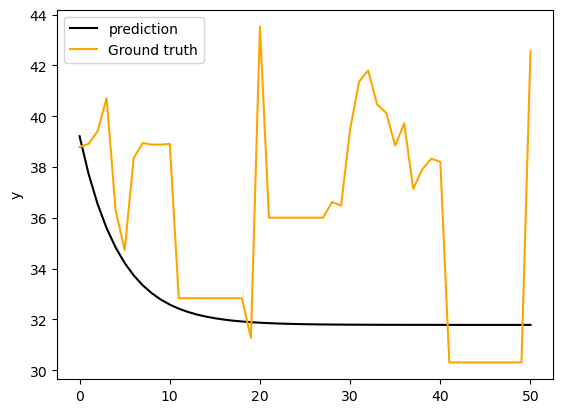

In [104]:
plt.plot(x_valid.index,y_pred,c='black',label='prediction')
sns.lineplot(x=x_valid.index, y=y_valid['y'],color='orange', label='Ground truth')
plt.legend()
plt.show()

The predictions aren't good. This is because:
- The data available was insufficent
- The data had multiple temperatures in the same day at differnt times. But we took into account only everyday values.
- The null values were filled by us.